# 🏘️ Zillow Tax

## ✔️ Goals:
- Explore associations to tax amount and house attributes
- Predict the price of a home utilizing regression machine learning models

## 📦 Imports

In [1]:
# My .py Modularization Files
import env
import os
import wrangle as w
import modeling as m 
# Ignore Warning
import warnings
warnings.filterwarnings("ignore")
# Array and Dataframes
import numpy as np
import pandas as pd
# Evaluation: Visualization
import seaborn as sns
import matplotlib.pyplot as plt
plt.style.use('fivethirtyeight')
# Evaluation: Statistical Analysis
from scipy import stats
# Modeling: Preprocessing
    # Encoder
from sklearn.preprocessing import OrdinalEncoder
    # Scalers
from sklearn.preprocessing import QuantileTransformer, MinMaxScaler, StandardScaler, RobustScaler
# Modeling: Feature Selection
from sklearn.feature_selection import SelectKBest, f_regression, RFE
# Modeling
    # OLS - Ordinary Least Squares
from sklearn.linear_model import LinearRegression as lr
    # LASSO LARS - Least Absolute Shrinkage & Selection Operator |  Least Angle Regression Selection
from sklearn.linear_model import LassoLars
    # Generalized Linear Model
from sklearn.linear_model import TweedieRegressor
    # Polynomial
from sklearn.preprocessing import PolynomialFeatures
# Modeling: Selection
    # Splitter
from sklearn.model_selection import train_test_split
    # Algorithmic Optimization
from sklearn.model_selection import GridSearchCV
# Metrics
from sklearn.metrics import r2_score, mean_squared_error, explained_variance_score

## 🎣 Acquire

- Left joined properties_2017 & predictions_2017
- Data had 9 columns and 55736 rows after preparation
- Columns are representative of data relative to home attributes
- Rows are representative of individual homes and their respective data 
 

In [2]:
zillow = w.zillow()

File exists, pulling from system.


## 🍱 Prepare
- Cleaned null or duplicate data
- Encoded multicategorical type data with dummy columns
- Dropped all useless dummy columns
- Normalized numerical data by dropping extra symbols and spaces, changed type to numeric type
- Snake case columns
- Split data for training, validate and test (respectively; ~60,~20,~20)

In [3]:
train, validate, test = w.splitter(zillow)

Dataframe: (55736, 9) 100%
Train: (35670, 9) | ~60%
Validate: (8918, 9) | ~20%
Test: (11148, 9) | ~20%


## 📒 Data Dictionary
--- 
| Feature        | Definition                                   |
| ---            | ---                                          |
| bedroomcnt     | int; a count of how many bedrooms in the house |
| bathroomcnt    | float; a count of how many bathrooms in the house |
| sq_feet    | int; the total sq footage of the property |
| tax_value        | int; **target** the predetermined tax value assessed off property value |
| yearbuilt    | int; the year the respective property was built |
| county         | string; the county the property is located in |

## 🎞️ Data Preview

In [8]:
# view all columns with associated values to observe
pd.set_option('display.max_columns', None)

In [9]:
# random sample of data to examine
train.sample(5)

,bedroomcnt,bathroomcnt,sq_feet,tax_value,yearbuilt,county,la,orange,ventura
25756,3,2.0,1268,699506,1924,LA,1,0,0
21331,4,5.0,4502,1620794,2005,LA,1,0,0
46979,2,2.0,1209,248947,1949,LA,1,0,0
16290,2,1.0,1380,456862,1942,LA,1,0,0
45605,3,2.0,1157,150000,1972,LA,1,0,0


In [10]:
train.info()

<class 'pandas.core.frame.DataFrame'>
Index: 35670 entries, 41368 to 46060
Data columns (total 9 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   bedroomcnt   35670 non-null  int64  
 1   bathroomcnt  35670 non-null  float64
 2   sq_feet      35670 non-null  int64  
 3   tax_value    35670 non-null  int64  
 4   yearbuilt    35670 non-null  int64  
 5   county       35670 non-null  object 
 6   la           35670 non-null  int64  
 7   orange       35670 non-null  int64  
 8   ventura      35670 non-null  int64  
dtypes: float64(1), int64(7), object(1)
memory usage: 2.7+ MB


## 🧭 Explore

### Explore: Feature Engineering

In [6]:
# Compiling all additional services into a column that would measure the sum of services subscribed
train['additional_services'] = (train[['device_protection','online_security','streaming_movies','streaming_tv','online_backup','tech_support']] == 'Yes').sum(axis=1)
validate['additional_services'] = (train[['device_protection','online_security','streaming_movies','streaming_tv','online_backup','tech_support']] == 'Yes').sum(axis=1)
test['additional_services'] = (train[['device_protection','online_security','streaming_movies','streaming_tv','online_backup','tech_support']] == 'Yes').sum(axis=1)

In [7]:
# Function to loop through desired df and respective columns to visualize
cat_cols, num_cols = m.organize_columns(train)
# Compiled categorical columns
cat_cols = train[cat_cols]

## 1. Tax Values visualized and baseline set.

TypeError: plot() got an unexpected keyword argument 'x'

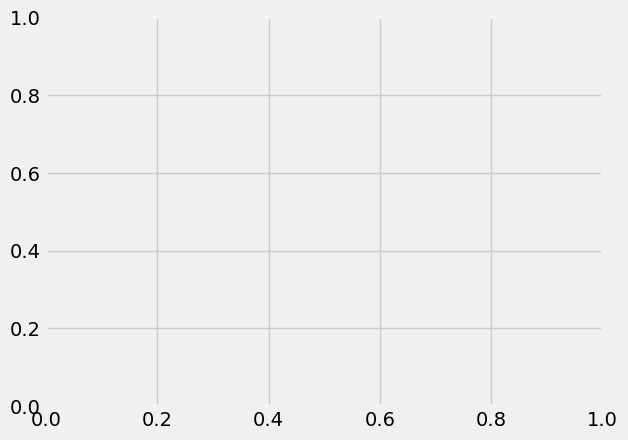

In [18]:
# Percentage of customers that churn ( also our baseline prediction, 73.5% )


Establish our understanding of target and moving forward with modeling we establish our baseline of *~73.5%* as well as visualize the distribution.
---
___

## 2. The longer the customer has been with the company the less likely they are to churn due to ease of services.


**Set null Hypothesis to examine these two features**
___

Null $H_0$: There is **no** association between *churn* & *tenure*\
Null $H_a$: There *is* an association between *churn* & *tenure*

In [9]:
# Masking & defining our desired values
tenure_churned = train[train.churn == 'Yes']['tenure']
tenure_nochurn = train[train.churn == 'No']['tenure']

# Set alpha
α = .05
# Assuming equal variance
t_stat, p = stats.ttest_ind(tenure_churned,tenure_nochurn,equal_var=True)
p

m.check_p(p)

We can reject the null hypothesis with a p-score of: {5.213539721523729e-130}


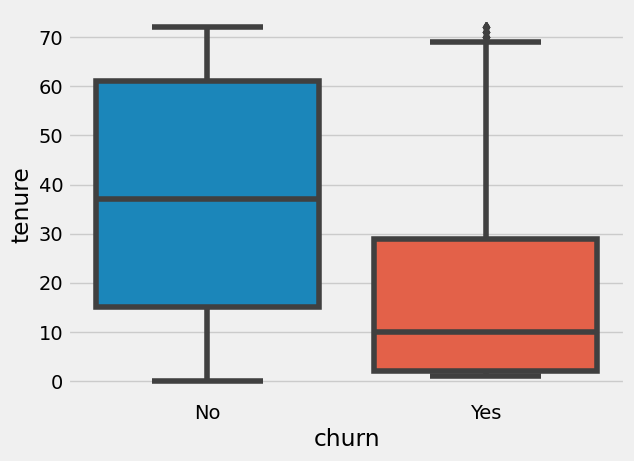

In [10]:
z = sns.boxplot(data=train,x='churn',y='tenure')


There is a **negative** correlation to tenure, meaning customers that have been with the company longer are likely to remain.
---
___

## 3. If monthly payments are too high the customer will likely churn, due to seeing the service as too expensive.

**Set null Hypothesis to examine these two features**
___

Null $H_0$: There is **no** association between *churn* & *monthly_charges*\
Null $H_a$: There *is* an association between *churn* & *monthly_charges*

In [11]:
train.groupby('churn')['monthly_charges'].mean()

monthly_churned = train[train.churn == 'Yes']['monthly_charges']
monthly_nochurn = train[train.churn == 'No']['monthly_charges']

# Set alpha
α = .05
# Assuming equal variance
t_stat, p = stats.ttest_ind(monthly_churned,monthly_nochurn,equal_var=True)
p

m.check_p(p)

We can reject the null hypothesis with a p-score of: {1.481195740841378e-40}


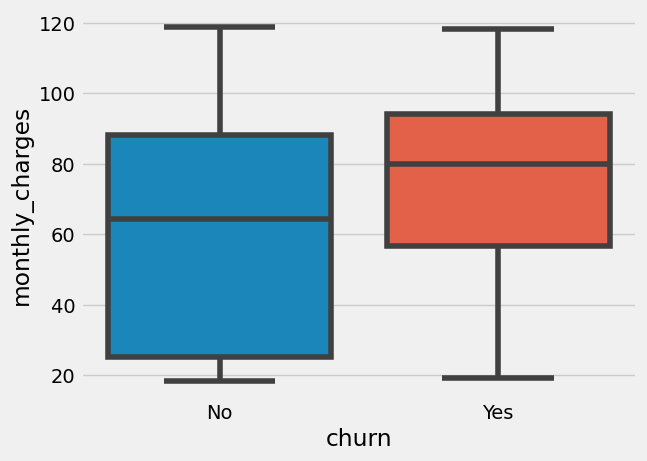

In [12]:
z = sns.boxplot(data=train,x='churn',y='monthly_charges')

The **IQR** (interquartile range) of customers that have churned is noticeably higher than those that have not\
A means comparison T-Test provides statistical evidence that monthly charges could be relative to churn.
---
___

## 4. The customer's contract plan may be indicative of how long they intend to be with the provider considering this would lower their window to churn?

**Set null Hypothesis to examine these two features**
___

Null $H_0$: There is **no** association between *churn* & having a *month-to-month contract*\
Null $H_a$: There *is* an association between *churn* & having a *month-to-month contract*

In [13]:
# conduct statistical analysis of churn x contract_type_month_to_month
m.chi2_test(train['churn_binary'],train['contract_type_month_to_month'])

We can reject the null hypothesis with a p-score of: {7.035284556920665e-158}


contract_type_month_to_month,0,1
churn_binary,,
0,1861,1450
1,135,1061


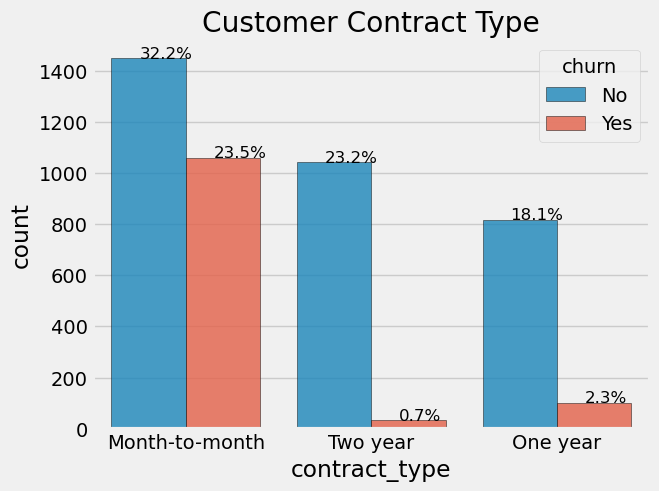

In [14]:
ax = sns.countplot(data=train,x='contract_type',hue='churn',alpha=0.8,linewidth=.4,edgecolor='black')
plt.title('Customer Contract Type')
m.without_hue(ax,train.contract_type)

There is a **positive** correlation to contract_type_month_to_month, this would be strongly indicative of an association between customer churn and contract type.
---
___

## 5. Customers that are senior citizen may be less likely to churn due to complications with changing plans.

**Set null Hypothesis to examine these two features**
___

Null $H_0$: There is **no** association between churn & senior citizens\
Null $H_a$: There *is* an association between churn & senior citizens

In [15]:
# conduct statistical analysis of churn x senior_citizen
m.chi2_test(train['churn'],train['senior_citizen'])

We can reject the null hypothesis with a p-score of: {2.7803174215206096e-25}


senior_citizen,0,1
churn,,
No,2888,423
Yes,888,308


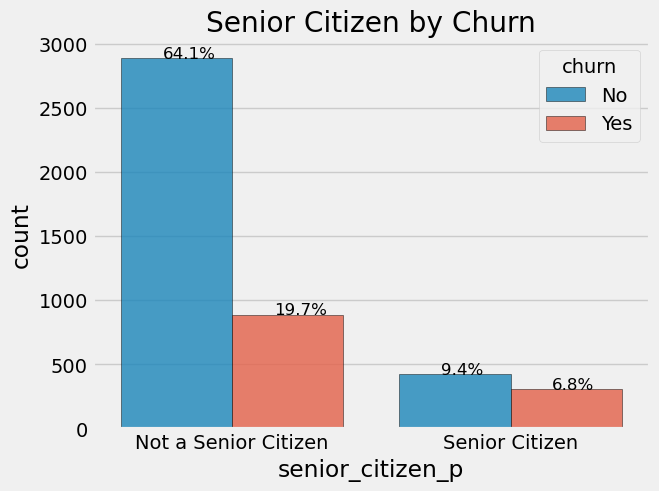

In [24]:
ax = sns.countplot(data=train,x='senior_citizen_p',hue='churn',alpha=0.8,linewidth=.4,edgecolor='black')#,labels=)
plt.title('Senior Citizen by Churn')
# yes and no for clarification
m.without_hue(ax,train.contract_type)

There is a **positive** correlation to senior_citizen, this would be indicative of an association between customer churn and senior_citizen, although this does not line up with our hypothesis it is still a feature to consider.\
Chi Squared ($\chi^2$) test results show that there is a **positive** association between the two 
features as well
---
___

## 6. Customer internet service plan quality could be a factor in whether a customer decides to stay with the company.

**Set null Hypothesis to examine these two features**
___

Null $H_0$: There is **no** association between churn & internet_service_type\
Null $H_a$: There *is* an association between churn & internet_service_type

In [17]:
m.chi2_test(train.churn,train.internet_service_type)

We can reject the null hypothesis with a p-score of: {1.6331025637406135e-103}


internet_service_type,DSL,Fiber optic,None
churn,,,
No,1272,1154,885
Yes,290,835,71


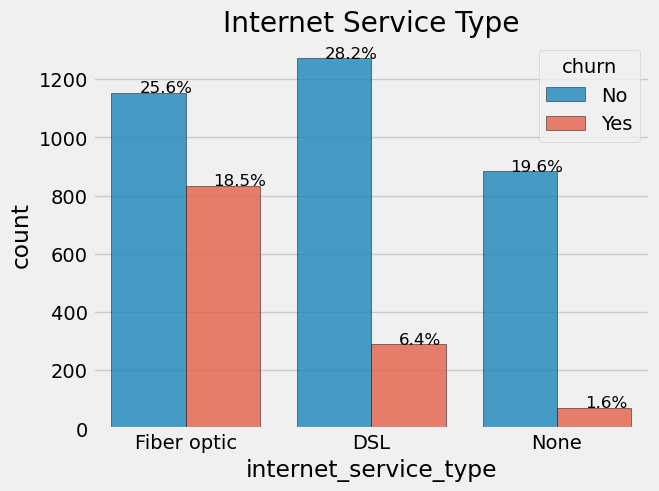

In [33]:
ax = sns.countplot(data=train,x='internet_service_type',hue='churn',alpha=0.8,linewidth=.4,edgecolor='black')
plt.title('Internet Service Type')
m.without_hue(ax,train.contract_type)

There is a **positive** correlation to internet_service_type, specifically *fiber optic plans*.
---
___

## ⛏️ Feature Selection
- monthly_charges
- tenure
- contract_type_month_to_month
- internet_service_type_fiber_optic
- senior_citizen
___

# 🎼 Modeling
Evaluation Metric: **Accuracy**\
Baseline Prediction: **73.5%**\
\
A *baseline prediction* is essentially the closest metric we have to predicting whether a customer will churn, without using a model.\
\
The models that will be used today are (*SKLearn Flavor*):
- **K Nearest Neighbor**
- **Decision Tree**
- **Logistic Regression**



In [19]:
# Defining feature variables for models
x_train = train[['monthly_charges','tenure','contract_type_month_to_month','internet_service_type_fiber_optic','senior_citizen']]
y_train = train['churn_binary']
y_train = y_train.values.ravel()

x_val = validate[['monthly_charges','tenure','contract_type_month_to_month','internet_service_type_fiber_optic','senior_citizen']]
y_val = validate['churn_binary']
y_val = y_val.values.ravel()

x_test = test[['monthly_charges','tenure','contract_type_month_to_month','internet_service_type_fiber_optic','senior_citizen']]
y_test = test['churn_binary']
y_test = y_test.values.ravel()

## 🐴 K Nearest Neighbors

In [20]:
# 🐴 K Nearest Neighbor with optimized results - GridSearchCV did not like
m.knn_compiled(x_train,y_train,x_test,y_test)

Best fit "n_neighbors" parameter (Determined by GridSearchCV): 28 
--------------------------------------
Train Class Report & Metrics:      
---------------------------------------
              precision    recall  f1-score   support

           0       0.99      0.99      0.99      3311
           1       0.97      0.98      0.97      1196

    accuracy                           0.99      4507
   macro avg       0.98      0.98      0.98      4507
weighted avg       0.99      0.99      0.99      4507

Accuracy: 0.985799866873752

True Positive Rate/Sensitivity/Recall/Power: 0.9765886287625418
False Positive Rate/False Alarm Ratio/Fall-out: 0.010872848082150407
True Negative Rate/Specificity/Selectivity: 0.9891271519178496
False Negative Rate/Miss Rate: 0.023411371237458192

Precision/PPV: 0.9700996677740864
F1 Score: 0.9733333333333334

Support (0): 1196
Support (1): 3311
None 

Test Classificiation Report & Metrics:      
--------------------------------------
              precisio

In [21]:
# 🐴 KNN with n_neighbors set to 7 for a more balanced accuracy

knn1 = KNeighborsClassifier(n_neighbors=7, weights='uniform')
knn1.fit(x_train,y_train)

model3_prediction = knn1.predict(x_train)
model3_probability = knn1.predict_proba(x_train)

model3_prediction_val = knn1.predict(x_val)
model3_probability_val = knn1.predict_proba(x_val)

model3_prediction_test = knn1.predict(x_test)
model3_probability_test = knn1.predict_proba(x_test)

## 🌴 Decision Tree

In [32]:
# 🌴 Decision Tree - if plot=True will return a plotted decision tree
m.decision_tree_compiled(x_train, y_train, x_val, y_val, train,plot=False)


#print('\n')
#m.decision_tree_compiled(x_val, y_val, validate, plot=False)

Accuracy: 0.791213667628134

True Positive Rate/Sensitivity/Recall/Power: 0.40217391304347827
False Positive Rate/False Alarm Ratio/Fall-out: 0.06825732407127756
True Negative Rate/Specificity/Selectivity: 0.9317426759287224
False Negative Rate/Miss Rate: 0.5978260869565217

Precision/PPV: 0.6803394625176803
F1 Score: 0.5055176037834996

Support (0): 1196
Support (1): 3311


In [ ]:
m.get_classification_report(y_test,model3_prediction_test)

,precision,recall,f1-score,support
0,0.825655,0.883092,0.853408,1035.000000
accuracy,0.777147,0.777147,0.777147,0.777147
weighted avg,0.765582,0.777147,0.769024,1409.000000
macro avg,0.712496,0.683525,0.694455,1409.000000
1,0.599338,0.483957,0.535503,374.000000


## 🪵 Logistic Regression

In [ ]:
# 🪵 Logistic Regression with Optimized results ()
m.log_regression_compiled(x_train,y_train,x_test,y_test)

Best fit "C" parameter (Determined by GridSearchCV): 0.2
Accuracy: 0.7934324384291103

True Positive Rate/Sensitivity/Recall/Power: 0.49414715719063546
False Positive Rate/False Alarm Ratio/Fall-out: 0.0984596798550287
True Negative Rate/Specificity/Selectivity: 0.9015403201449713
False Negative Rate/Miss Rate: 0.5058528428093646

Precision/PPV: 0.6444929116684842
F1 Score: 0.5593942262186465

Support (0): 1196
Support (1): 3311


## 🏆 Best Model - Modeling Summary

***Logistic regression*** had the best accuracy on <u>test set</u>  with: **79.34%**

**Decision Tree**\
Although performed just marginally worst; Decision Tree train set was on par but barely fell behind on test.\
\
**K Nearest Neighbor**\
GridSearchCV (an SKLearn optimization searching tool) heavily favored the train set and heavily overfit with an accuracy of **99%**,\
Heavily underperformed in the test set with **72%**.\
\
This was tested again with a *n_neighbors = 7* to balance but still underperformed with **77%** just barely beating baseline.


# 🥡 Conclusion / Takeaways

## Exploration
- Customers churned at a rate of **73.5%**
- Month to month contracts is one of the biggest drivers of churn with **23.5%** of all customers churning
- **Monthly charges** is seemingly a driver because most customers that churn are **fiber optic** customers, which is the most expensive plan
- The interquartile range of tenure in customers that did not churn is exponentially higher than that of customer that did
- With **16.2%** of the customers being senior citizens **6.8%** of that have churned
- In internet service plans we see **44.1%** of those customers use fiber optic and of that **18.5%** churn

## Modeling
- Models just merely outperformed baseline, this could be due to lack of data or significant features
- A majority of features were no factor

## Recommendations
- Lean into high paying & long tenure customers
- Offer deals for month-to-month contract customers to transition to two-year contracts
- Improve senior citizen experience, simplify services - service packages rather than multiple individual services
- For every year subscribed, get one free month of service (*regardless of contract type*)- this could make the monthly charges easier to pay

## Next Steps
- Run other models on same features
- Further combine features to see comparisons of churn